In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

# from IPython.display import display, Math, Latex

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import integrate
import scipy.stats as stats

import time

scale = 100
bank_coordinates = [(20 * scale, 25 * scale), (42 * scale, 40 * scale), (35 * scale, 5 * scale), (10 * scale, 42 * scale), (7 * scale, 5 * scale)]
scaled_bank_coordinates = []
for each_pair in bank_coordinates:
        scaled_bank_coordinates += [(each_pair[0] - 25 * scale, each_pair[1] - 25 * scale)]

# import tqdm

### We introduce a random variable $C_{s}$ indicate the cost of transportation within a closed region $s$. So we calculate the expected value of $C_s$ for each segment over random variable $L$ which denotes $L=(x,y)$, the location of each house.  $L$ comes from a bivaiate normal distibutions with given mean and variance.

$$ p(L)= p(x,y) = p(x)p(y) = N(\mu_1, \sigma_1) \times N(\mu_2, \sigma_2) $$

We draw the figure with the bank and the area around them which the brown color indicates the 1 transportation cost and the gray color indicates the 3 transportation cost and rest of the region has 5 transportation cost

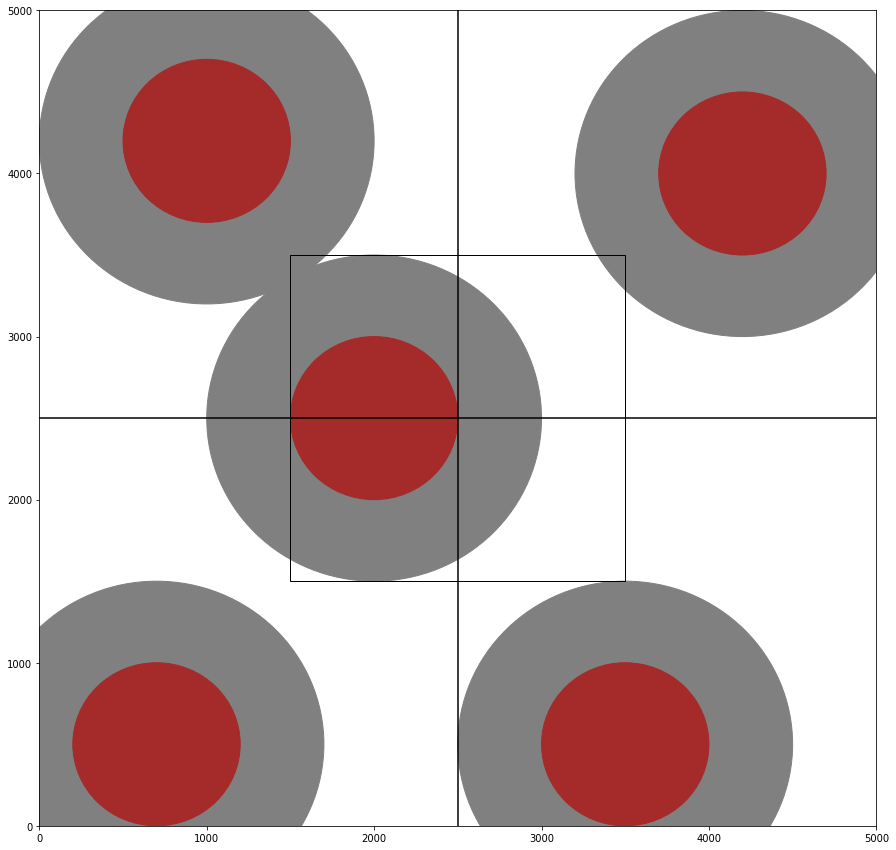

In [7]:
rect = patches.Rectangle((15 * scale, 15 * scale), 20 * scale, 20 * scale, linewidth=1, edgecolor='black', facecolor='none')

one_cost_cicles = []

for each_pair in bank_coordinates:
        one_cost_cicles += [plt.Circle(each_pair, 5 * scale, color='brown', fill=True)]

three_cost_cicles = []

for each_pair in bank_coordinates:
        three_cost_cicles += [plt.Circle(each_pair, 10 * scale, color='gray', fill=True)]


fig, ax = plt.subplots(figsize=(15,15))

ax = plt.gca()
ax.cla() # clear things for fresh plot

ax.set_xlim((0, 50 * scale))
ax.set_ylim((0, 50 * scale))

for cicle in three_cost_cicles:
    ax.add_patch(cicle)

for cicle in one_cost_cicles:
    ax.add_patch(cicle)

ax.add_patch(rect)

plt.hlines(2500, 0, 5000)
plt.vlines(2500, 0, 5000)


plt.show()


### We consider the center of the rectangle as the zero point of our coordinate

We assume the transpotation cost is given with function $g(x, y)$. Hence, we want to calculate the expectation of this function


$$E_L[g(x)] = \int_{s} g(x)p(l)dl = \int_{s}\int_s g(x)p(x)p(y)dxdy $$

In the first appoach we try to estimate indiectly by sampling from normal distriubtion, though in the second appoach we calculate the integrals directly with partially integrate over the whole grid.

## Calculating Cost

## First Approach

### For calculating the cost we act like the monto carlo method, we sample data points from normal distribution with the closed interval regions. Then we segment the whole grid into the $50 \times 50$ (the size of the square could be arbitary) square and calculate the transportation cost for each value. Simply, find the data point in each square and then search for the nearest bank and then calculate its transportation cost and at last sum over all the data point in the square.

With the following function we do the sampling
```
stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(2000)

```

In [12]:
def sample_whole__points():

    lower, upper = -1000, 1000
    mu, sigma = 0, 500
    x_in = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(2000)
    y_in = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(2000)

    lower, upper = -2500, 2500
    mu, sigma = 0, 1250
    x_out = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(6000)
    y_out = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(6000)
    
    return x_in, y_in, x_out, y_out


The above function simulate house with given constraint of the problem and return the data points.

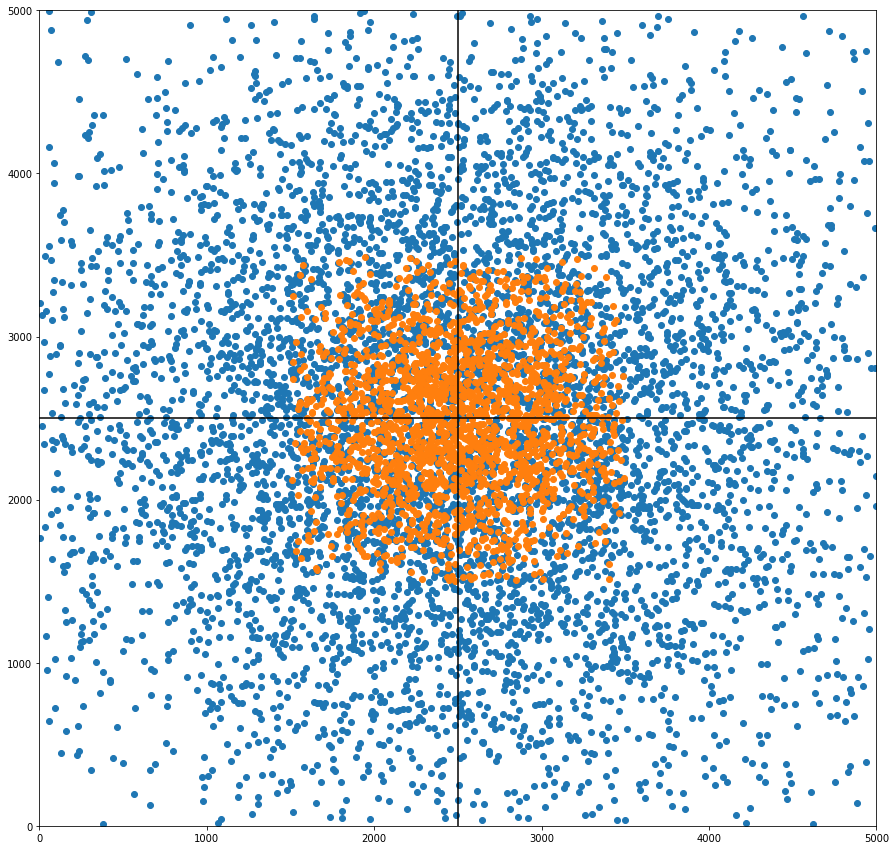

In [13]:
x_in, y_in, x_out, y_out = sample_whole__points()


fig, ax = plt.subplots(figsize=(15,15))

ax.set_xlim((0, 50 * scale))
ax.set_ylim((0, 50 * scale))

plt.hlines(2500, 0, 5000)
plt.vlines(2500, 0, 5000)

plt.scatter(x_out + 2500.0, y_out + 2500.0)
plt.scatter(x_in + 2500, y_in + 2500)

plt.show()

In [17]:
def calculate_cost(x, y, bank_list, return_bank=False):
    """
    This function calculate the transportation cost for a given data point.
    """
    distances = []
    for bank in bank_list:
        distances += [np.floor(np.sqrt(np.abs(x - bank[0]) ** 2 + np.abs(y - bank[1]) ** 2))]
    nearest_bank = np.argmin(distances)
    
    if return_bank:
        if distances[nearest_bank] <= 500:
            return 1, nearest_bank
        elif distances[nearest_bank] <= 1000:
            return 3, nearest_bank
        else:
            return 5, nearest_bank
    else:
        if distances[nearest_bank] <= 500:
            return 1
        elif distances[nearest_bank] <= 1000:
            return 3
        else:
            return 5

def calculate_probability(x, y, in_):
    if in_:
        return stats.norm(0, 500).pdf(x) * stats.norm(0, 500).pdf(y)
    else:
        return stats.norm(0, 1250).pdf(x) * stats.norm(0, 1250).pdf(y)
    
def calculate_expectation_for_each_element(x_min, x_max, y_min, y_max,
                                           sampled_tuple, bank_list):
  
    """
    This function calculate the sum of transpotation cost for each house in the given square.
    """
        
    x_sampled_in, y_sampled_in, x_sampled_out, y_sampled_out = sampled_tuple
    expected_value_in = 0
    filtered_y = y_sampled_in[(x_sampled_in <= x_max) & (x_sampled_in >= x_min)]
    filtered_x = x_sampled_in[(x_sampled_in <= x_max) & (x_sampled_in >= x_min)]
    
    filtered_x = filtered_x[(filtered_y <= y_max) & (filtered_y >= y_min)]
    filtered_y = filtered_y[(filtered_y <= y_max) & (filtered_y >= y_min)]
    
    if len(filtered_y) != len(filtered_x):
        print("ERORR")
        return
    
    def function_for_vector(i):
      return calculate_cost(filtered_x[i], filtered_y[i], bank_list)
    v_func = np.vectorize(function_for_vector)

    if len(filtered_y) > 0:
          expected_value_in = np.sum(v_func(np.arange(filtered_x.shape[0])))
    expected_value_out = 0
    filtered_y = y_sampled_out[(x_sampled_out <= x_max) & (x_sampled_out >= x_min)]
    filtered_x = x_sampled_out[(x_sampled_out <= x_max) & (x_sampled_out >= x_min)]
    
    filtered_x = filtered_x[(filtered_y <= y_max) & (filtered_y >= y_min)]
    filtered_y = filtered_y[(filtered_y <= y_max) & (filtered_y >= y_min)]
    
    if len(filtered_y) != len(filtered_x):
        print("ERORR")
        return
    if len(filtered_y) > 0:
          expected_value_out = np.sum(v_func(np.arange(filtered_x.shape[0])))
    return expected_value_out + expected_value_in

def overall_monto_carlo(element_size, bank_list):

    """
      This function operate the monto carlo sampling for one step, it calculate the transportation cost for all the square in the main grid.
    """
    
    iterations = int(5000 / element_size)
    result_matrix_square = np.zeros((5000, 5000))
    
    sampled_points = sample_whole__points()

    indices = np.transpose([np.tile(np.arange(iterations), iterations), np.repeat(np.arange(iterations), iterations)])

    def calculate_cost_for_single_squae(i):
      result_matrix_square[indices[i][1] * element_size:(indices[i][1] + 1) * element_size, indices[i][0] * element_size: (indices[i][0] + 1) * element_size] = calculate_expectation_for_each_element(
          (-25 * scale) + indices[i][1] * element_size,
          (-25 * scale) + (indices[i][1] + 1) * element_size,
          (-25 * scale) + indices[i][0] * element_size,
          (-25 * scale) + (indices[i][0] + 1) * element_size, sampled_points, bank_list)

    v_func = np.vectorize(calculate_cost_for_single_squae)
    v_func(np.arange(iterations * iterations))

    return result_matrix_square



def simulation_situation(number_of_iteration, element_size, bank_list):
    """
      The whole monto carlo procedure which sample for number_of_iteration steps and mean over all the calculated values.
    """
    all_results_matrix = np.zeros((50 * scale, 50 * scale))
    
    s_t = 0
    for i in range(number_of_iteration):
        if i == 0:
            s_t = time.time()
        result_matrix_square = overall_monto_carlo(element_size, bank_list)
        all_results_matrix += result_matrix_square
        if i == 0:
            print("First iteration take", time.time() - s_t, "second to be completed")
    print("All time needed is:", time.time() - s_t)
    return all_results_matrix / (number_of_iteration * 1.0)


## The above functions has wroten efficiently via vectorization of numpy. It's computationally efficient.

In [19]:
result_matrix_square_batch = [simulation_situation(40, 50, scaled_bank_coordinates)]
result_matrix_square_batch += [simulation_situation(40, 100, scaled_bank_coordinates)]
result_matrix_square_batch += [simulation_situation(40, 250, scaled_bank_coordinates)]
result_matrix_square_batch += [simulation_situation(40, 500, scaled_bank_coordinates)]

First iteration take 1.9562456607818604 second to be completed
All time needed is: 77.75795006752014
First iteration take 0.924163818359375 second to be completed
All time needed is: 52.277010917663574
First iteration take 0.60390305519104 second to be completed
All time needed is: 24.575275182724
First iteration take 0.573768138885498 second to be completed
All time needed is: 23.009636402130127


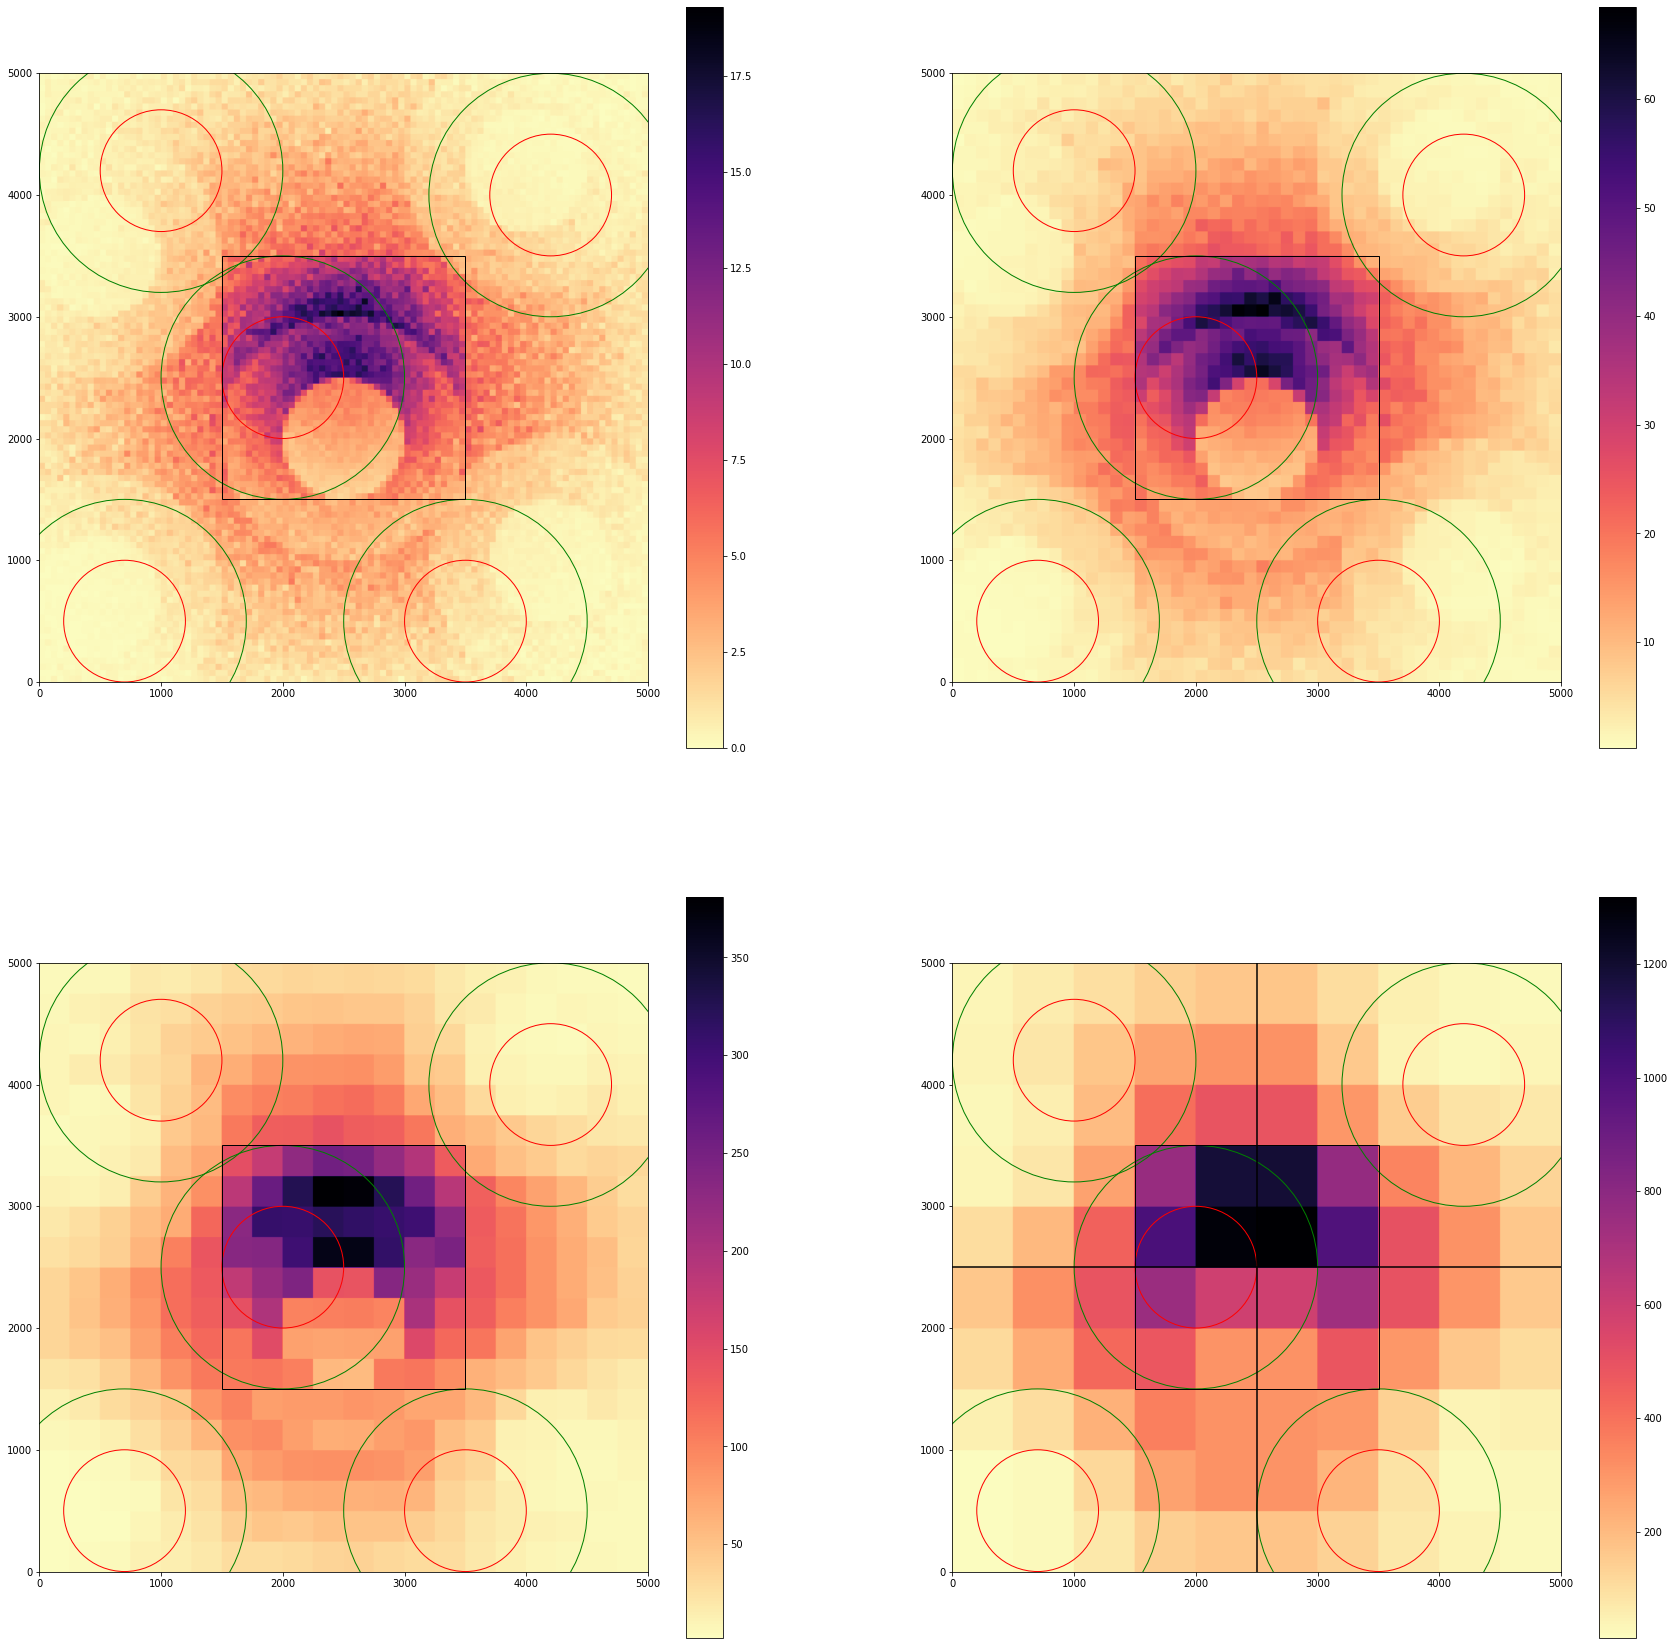

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(30,30))

for i in range(2):
  for j in range(2):
    im = ax[i][j].imshow(result_matrix_square_batch[i * 2 + j], cmap="magma_r")

    rect = patches.Rectangle((15 * scale, 15 * scale), 20 * scale, 20 * scale, linewidth=1, edgecolor='black', facecolor='none')

    cbar = ax[i][j].figure.colorbar(im, ax=ax[i][j])

    bank_coordinates = [(20 * scale, 25 * scale), (42 * scale, 40 * scale), (35 * scale, 5 * scale), (10 * scale, 42 * scale), (7 * scale, 5 * scale)]
    scaled_bank_coordinates = []
    for each_pair in bank_coordinates:
            scaled_bank_coordinates += [(each_pair[0] - 25 * scale, each_pair[1] - 25 * scale)]

    one_cost_cicles = []

    for each_pair in bank_coordinates:
            one_cost_cicles += [plt.Circle(each_pair, 5 * scale, color='r', fill=False)]

    three_cost_cicles = []

    for each_pair in bank_coordinates:
            three_cost_cicles += [plt.Circle(each_pair, 10 * scale, color='g', fill=False)]

    ax[i][j].set_xlim((0, 50 * scale))
    ax[i][j].set_ylim((0, 50 * scale))

    for cicle in three_cost_cicles:
        ax[i][j].add_patch(cicle)

    for cicle in one_cost_cicles:
        ax[i][j].add_patch(cicle)

    ax[i][j].add_patch(rect)

plt.hlines(2500, 0, 5000)
plt.vlines(2500, 0, 5000)


plt.show()

## As you can see the above plot indicate the areas which have the highest transpotation costs and advertisting on those area are the most profitable indeed. The darker the color the highest the cost it is. There are four different subplots which each of them has been drawn with different resolutions 50, 100, 250, 500 for mmaking the decison making for Baloon chiefs easier :D

# Second Approach

## In the second approach we drive the solution via mathematical modeling. Despite of the first one we calculate integral directly. We assume small square elements with size $10 \times 10$ in the grid and calculate integral over them. Now assume a square wich overlap with one of the curve of the banks, like below:
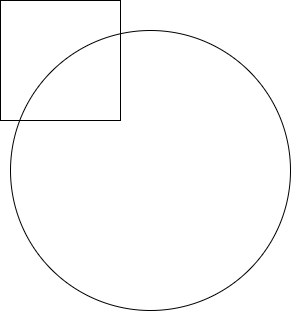 

Suppose the curve comes from the equation 

$$(x - a) + (y - a) = r^2 $$

So we get the following integral over the square (s, with langth d = 10) the left, below point of square is $(x_0, y_0)$ point :

$$E_{x,y}[g(x, y)|s] = \int \int_s g(x,y)p(x)p(y)dxdy $$
$$ = \int_{x=x_0}^{x=x_0 + d} \int^{y_0 + d}_{y^2 < x^2 + \alpha a + \beta b + \gamma r^2} g(x,y)p(x)p(y)dxdy + \int_{x=x_0}^{x=x_0 + d} \int_{y_0}^{y^2 \geq x^2 + \alpha a + \beta b + \gamma r^2} g(x,y)p(x)p(y)dxdy$$

So in algorithmic overview we use the dynamic programming to indicate the equation of the curve. As a preprocess step we set for each point in the square what circle with what radius is the closest one. Then for square $S$ we should have two set of pairs of radius and center which the one with the lowest radius should be the equation of the curve (The proof of this claim is very easy) . Then we calculate the integral easily with given interval for x and give equation for y using the following function.

```
from scipy.integrate import dblquad
def I(n):
    return dblquad(lambda y, x: x^2 + y^2, 0, y_0, lambda x: 1, lambda x: x_0)
```

And if no curve crosses the square, then it's a very simple integral to calculate which I will pass from explaining it.

Note that we assume for each square that only one curve will pass it and due to the small size of squares it's a reasonable assumption.


# We didn't implemente this approach because the last approach has the proper results but this approch worth to mention.


# **Second Part**

## The idea for the second question is that similarly we divide the square to several subsqure with width 50 and assume that each new bank would be located at the center of that square.

# Now assume we fix the location of the new bank somewhere in the main grid. Likewise the first approach of the last part we sample a population with given constraint of the problem from bivariate normal distribution. Now we calculate the transportation of each house without considering the newly added bank. Suppose we have transpotation cost $T_0$ at the beginning. Now we add a new bank and calculate the transportation cost again with new bank being added. The new value would be $T_{i, j}$, (i, j) is the coordinate of the new bank. Now the reduced cost of bank being in the location (i, j) would be:


$$ T - T_{i, j}$$

# It is obviouse thatt $T$ is greater equal than $T_{i, j}$, becuase with adding a new bank we have some points with greater than 1 transporation cost which have 1 cost now, and if the bank is exactly in the same location of the other banks then $T = T_{i, j}$. So we calculate value for each new location and draw the required heatmap.

# The size of grid is too lage so we need a vey efficient algorithm to calculate the reduced costs. At first with the DP idea we calculate all the costs for each data point, then we find the data points within the square of $1000 \times 1000$ around the new bank and update their cost due to the apearance of the new bank and at last sum over all the data point's costs again.

# All the functions in the following code are vectorzied due to the large scale of the problem, so it's run very effcient.

In [ ]:
def calculate_cost_for_all_points():
  s_t = time.time()  

  x_in, y_in, x_out, y_out = sample_whole__points()
  x = np.concatenate([x_in, x_out])
  y = np.concatenate([y_in, y_out])

  current_bank_coordinates = scaled_bank_coordinates

  def calculate_cost_fast(x, y):

    distances = []

    for bank in current_bank_coordinates:
        distances += [np.floor(np.sqrt(np.abs(x - bank[0]) ** 2 + np.abs(y - bank[1]) ** 2))]
    nearest_bank = np.argmin(distances)

    if distances[nearest_bank] <= 500:
        return 1
    elif distances[nearest_bank] <= 1000:
        return 3
    else:
        return 5

  cost_points = np.vectorize(calculate_cost_fast)(x, y)

  first_cost = np.sum(cost_points)

  def calculate_cost_for_single_point(i, j):

    current_bank_coordinates = scaled_bank_coordinates + [(i, j)]

    def calculate_cost_fast(x, y):
      distances = []

      for bank in current_bank_coordinates:
          distances += [np.floor(np.sqrt(np.abs(x - bank[0]) ** 2 + np.abs(y - bank[1]) ** 2))]
      nearest_bank = np.argmin(distances)

      if distances[nearest_bank] <= 500:
          return 1
      elif distances[nearest_bank] <= 1000:
          return 3
      else:
          return 5

    rad = 1000

    check_x = x[np.where(((x <= i + rad) & (x >= i - rad)) & ((y <= j + rad) & (y >= j - rad)))]
    check_y = y[np.where(((x <= i + rad) & (x >= i - rad)) & ((y <= j + rad) & (y >= j - rad)))]

    new_cost = np.vectorize(calculate_cost_fast)(check_x, check_y)

    cost_points[np.where(((x <= i + rad) & (x >= i - rad)) & ((y <= j + rad) & (y >= j - rad)))] = new_cost

    return first_cost - np.sum(cost_points)




  element_size = 75

  iterations = int(5000 / element_size)
  result_matrix_square = np.zeros((5000, 5000))
  
  sampled_points = sample_whole__points()

  indices = np.transpose([np.tile(np.arange(iterations), iterations), np.repeat(np.arange(iterations), iterations)])

  def calculate_cost_for_single_squae(i):
    result_matrix_square[indices[i][1] * element_size: (indices[i][1] + 1) * element_size,
                         indices[i][0] * element_size: (indices[i][0] + 1) * element_size] =\
                          np.vectorize(calculate_cost_for_single_point)(int((indices[i][1] * element_size + (indices[i][1] + 1) * element_size) / 2) - 2500, int((indices[i][0] * element_size + (indices[i][0] + 1) * element_size) / 2) - 2500)

  v_func = np.vectorize(calculate_cost_for_single_squae)
  v_func(np.arange(iterations * iterations))


  print(time.time() - s_t)

  return result_matrix_square

In [ ]:
matrix_result = calculate_cost_for_all_points()

563.1720993518829


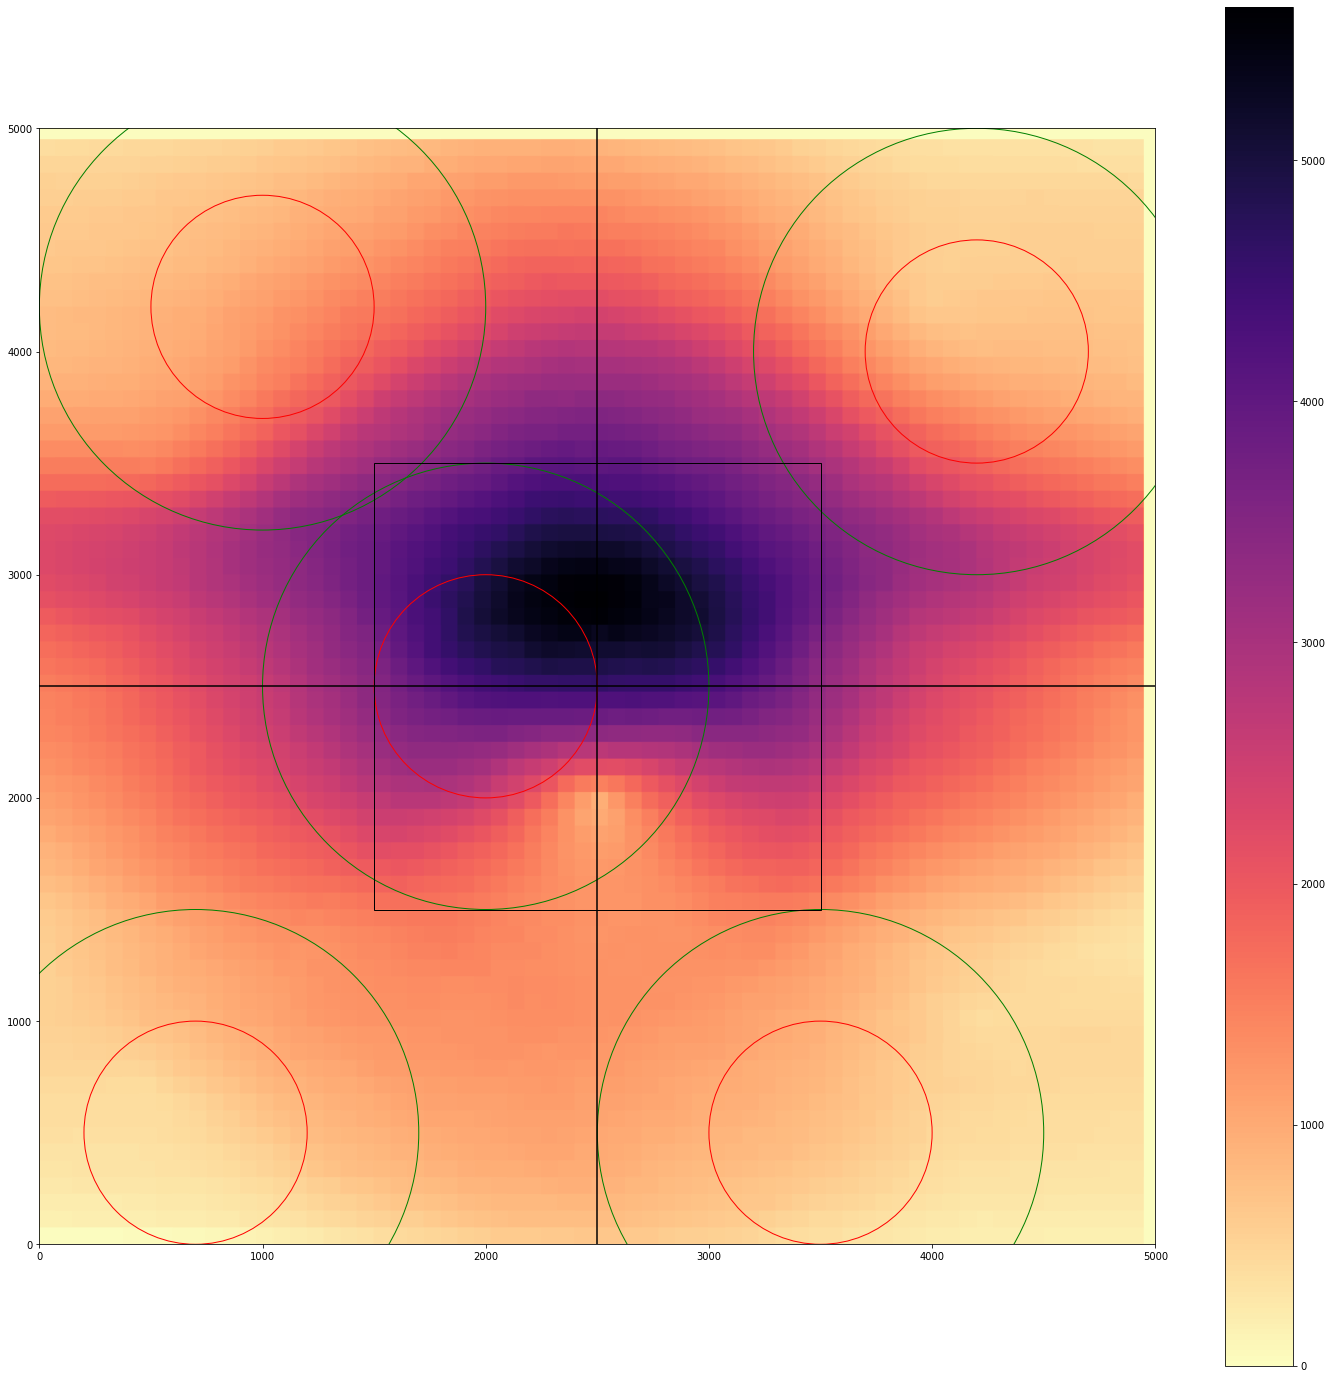

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))

im = ax.imshow(matrix_result, cmap="magma_r")

rect = patches.Rectangle((15 * scale, 15 * scale), 20 * scale, 20 * scale, linewidth=1, edgecolor='black', facecolor='none')

cbar = ax.figure.colorbar(im, ax=ax)

bank_coordinates = [(20 * scale, 25 * scale), (42 * scale, 40 * scale), (35 * scale, 5 * scale), (10 * scale, 42 * scale), (7 * scale, 5 * scale)]
scaled_bank_coordinates = []
for each_pair in bank_coordinates:
        scaled_bank_coordinates += [(each_pair[0] - 25 * scale, each_pair[1] - 25 * scale)]

one_cost_cicles = []

for each_pair in bank_coordinates:
        one_cost_cicles += [plt.Circle(each_pair, 5 * scale, color='r', fill=False)]

three_cost_cicles = []

for each_pair in bank_coordinates:
        three_cost_cicles += [plt.Circle(each_pair, 10 * scale, color='g', fill=False)]

ax.set_xlim((0, 50 * scale))
ax.set_ylim((0, 50 * scale))

for cicle in three_cost_cicles:
    ax.add_patch(cicle)

for cicle in one_cost_cicles:
    ax.add_patch(cicle)

ax.add_patch(rect)

plt.hlines(2500, 0, 5000)
plt.vlines(2500, 0, 5000)


plt.show()